In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [2]:
"""Import packages."""

# Standard library imports
import math
import os
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime
from functools import partial
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

# IPython and Jupyter-related imports
import ipywidgets as widgets
from IPython.display import clear_output, display

# Third-party libraries
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import temporaldata as td
import torch as t
from einops import (
    asnumpy,
    einsum,
    pack,
    parse_shape,
    rearrange,
    reduce,
    repeat,
    unpack,
)
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from scipy import stats
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from temporaldata import Data
from torch import Tensor, bfloat16, nn
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

# Local project modules
from mini import train as mt
from mini.util import vec_r2

In [3]:
# Set max rows and cols for df display
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

In [4]:
def clean_session_data(session):
    """Clean session data by filtering trials and spikes based on quality criteria."""
    
    # Mark Churchland gave me a matlab script which I have converted to python

    num_trials = len(session.trials.start)
    # I think is_valid is already defined by brainsets as (session.trials.discard_trial == 0) & (session.trials.task_success == 1) so it's a bit redundant but including it all just to be sure
    # In theory I should also filter based on whether the maze was possible or not (a field called "unhittable") but I cannot find this in the data, perhaps this has already been done in this release of the data
    good_trials = (session.trials.trial_type > 0) & (session.trials.is_valid == 1) & (session.trials.discard_trial == 0) & (session.trials.novel_maze == 0) & (session.trials.trial_version < 3) 
    session.trials = session.trials.select_by_mask(good_trials)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out extraneous trials, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    success = (session.trials.task_success == 1)
    session.trials = session.trials.select_by_mask(success)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out unsuccessful trials, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    post_move = 0.8 # to be kept, there must be at least this many ms after the movement onset
    long_enough = (session.trials.end - session.trials.move_begins_time >= post_move) # should essentially always be true for successes
    session.trials = session.trials.select_by_mask(long_enough)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out trials that were too short, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    consistent = (session.trials.correct_reach == 1)
    session.trials = session.trials.select_by_mask(consistent)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out trials with inconsistent reaches (not similar enough to the \"prototypical\" trial), went from", num_trials, "trials to", new_num_trials)

    primary_conditions = np.unique(session.trials.maze_condition)
    num_conditions = len(primary_conditions)
    print("Number of primary conditions:", num_conditions)
    # Check to make sure they are monotonic, starting from 1 and counting up
    if min(primary_conditions) != 1 or len(np.unique(np.diff(primary_conditions))) != 1:
        raise ValueError("Primary conditions are not monotonic or do not start from 1")

    # In theory I should filter units based on a ranking from 1-4 but I cannot find the ranking in the data, perhaps this has already been done in this release of the data

    # Only keep spikes that are within the cleaned trials
    session.spikes = session.spikes.select_by_interval(session.trials)
    session.hand = session.hand.select_by_interval(session.trials)
    session.eye = session.eye.select_by_interval(session.trials)

    # Convert session recording date to timestamp
    session.session.recording_date = datetime.strptime(session.session.recording_date, '%Y-%m-%d %H:%M:%S')
    session.session.recording_date = session.session.recording_date.timestamp()
    
    return session

In [5]:
def analyze_maze_conditions(session):
    """
    Analyze what each maze_condition corresponds to in terms of 
    maze parameters (barriers, targets, hit position).
    """
    
    # Get unique maze conditions
    unique_conditions = np.unique(session.trials.maze_condition)
    
    # Create a summary for each condition
    condition_summary = []
    
    for condition in unique_conditions:
        # Get trials for this condition
        condition_mask = session.trials.maze_condition == condition
        
        # Get the unique values for this condition
        barriers = np.unique(session.trials.maze_num_barriers[condition_mask])
        targets = np.unique(session.trials.maze_num_targets[condition_mask])
        hit_position = np.unique(session.trials.hit_target_position[condition_mask], axis=0)
        if len(hit_position) > 1:
            raise ValueError(f"Condition {condition} has multiple hit positions: {hit_position}")
        else:
            hit_position = hit_position[0]
        
        # Count trials for this condition
        num_trials = np.sum(condition_mask)
        
        # Store for summary table
        condition_summary.append({
            'Maze Condition': condition,
            'Trials': num_trials,
            'Barriers': barriers,
            'Targets': targets,
            'Hit Position': hit_position, 
            'Hit Position Angles': str(np.degrees(np.arctan2(hit_position[1], hit_position[0])))
        })
    summary_df = pd.DataFrame(condition_summary)
    
    # Convert hit positions to tuples temporarily for proper duplicate detection
    summary_df_temp = summary_df.copy()
    summary_df_temp['Hit Position Tuple'] = summary_df_temp['Hit Position'].apply(tuple)
    plot_df = summary_df_temp.drop_duplicates(subset=['Hit Position Tuple'], keep='first')
    plot_df = plot_df.drop('Hit Position Tuple', axis=1)  # Remove the temporary column
    
    # Create a proper DataFrame for plotting
    plot_data = pd.DataFrame({
        'Hit Position X': plot_df['Hit Position'].apply(lambda x: x[0]),
        'Hit Position Y': plot_df['Hit Position'].apply(lambda x: x[1]),
        'Maze Condition': plot_df['Maze Condition'].astype(str)
    })
    
    # Generate unique colors for each maze condition
    import plotly.colors as pc
    n_conditions = len(plot_data['Maze Condition'].unique())
    colors = pc.sample_colorscale('viridis', [i/(max(n_conditions-1, 1)) for i in range(n_conditions)])
    
    # Plot hit position by maze condition
    fig = px.scatter(
        plot_data,
        x='Hit Position X',
        y='Hit Position Y',
        color='Maze Condition',
        labels={'Hit Position X': 'Hit Position X', 'Hit Position Y': 'Hit Position Y', 'color': 'Maze Condition'},
        title='Hit Position by Maze Condition',
        color_discrete_sequence=colors,
        hover_data=['Maze Condition']
    )
    
    fig.update_layout(
        xaxis=dict(scaleanchor="y", scaleratio=1, range=[-150, 150]),
        yaxis=dict(constrain="domain", range=[-100, 100]),
        width=600,
        height=600
    )
    fig.show()
    
    return summary_df

In [6]:
# Path to your data directory
data_path = r"C:\Users\pouge\Documents\mini_data\brainsets\processed\churchland_shenoy_neural_2012"
# data_path = "/ceph/aeon/aeon/SANe/brainsets_data/processed/churchland_shenoy_neural_2012"
data_path = Path(data_path)

# List all h5 files in the directory
h5_files = [f for f in os.listdir(data_path) if f.endswith('.h5')]
print(f"Available h5 files: {h5_files}")

# User parameters
subject_name = "nitschke"  # Change to "nitschke" or "jenkins"
num_files_to_load = 3     # Change to desired number of files, max 6 (only 3 work) for nitschke, 4 for jenkins

# Filter files by subject
subject_files = [f for f in h5_files if subject_name.lower() in f.lower()]
print(f"\nFiles for subject {subject_name}: {subject_files}")

if len(subject_files) == 0:
    print(f"No files found for subject {subject_name}")
elif len(subject_files) < num_files_to_load:
    print(f"Only {len(subject_files)} files available for {subject_name}, loading all of them")
    num_files_to_load = len(subject_files)

# Load and clean the specified number of files
sessions = []
for i in range(min(num_files_to_load, len(subject_files))):
    file_path = os.path.join(data_path, subject_files[i])
    print(f"\nLoading file {i+1}/{num_files_to_load}: {subject_files[i]}")
    
    # Read neural data from HDF5
    with h5py.File(file_path, "r") as f:
        session = Data.from_hdf5(f)

        session.spikes.materialize()
        session.trials.materialize()
        session.hand.materialize()
        session.eye.materialize()
        session.session.materialize()

        print("Session ID: ", session.session.id)
        print("Session subject id: ", session.subject.id)
        print("Session subject sex: ", session.subject.sex)
        print("Session subject species: ", session.subject.species)
        print("Session recording date: ", session.session.recording_date)
        print("Original number of trials:", len(session.trials.start))
        
        # Clean the session data
        try:
            session = clean_session_data(session)
            print("Final number of trials after cleaning:", len(session.trials.start))

            print("Summary of primary conditions:")
            primary_conditions_summary = analyze_maze_conditions(session)
            display(primary_conditions_summary)
            
            sessions.append(session)
        except Exception as e:
            print(f"Error processing session {session.session.id}: {e}")
            continue

print(f"\nSuccessfully loaded and cleaned {len(sessions)} sessions for subject {subject_name}")

Available h5 files: ['jenkins_20090912_center_out_reaching.h5', 'jenkins_20090916_center_out_reaching.h5', 'jenkins_20090918_center_out_reaching.h5', 'jenkins_20090923_center_out_reaching.h5', 'nitschke_20090812_center_out_reaching.h5', 'nitschke_20090819_center_out_reaching.h5', 'nitschke_20090910_center_out_reaching.h5', 'nitschke_20090920_center_out_reaching.h5', 'nitschke_20090922_center_out_reaching.h5', 'nitschke_20100923_center_out_reaching.h5']

Files for subject nitschke: ['nitschke_20090812_center_out_reaching.h5', 'nitschke_20090819_center_out_reaching.h5', 'nitschke_20090910_center_out_reaching.h5', 'nitschke_20090920_center_out_reaching.h5', 'nitschke_20090922_center_out_reaching.h5', 'nitschke_20100923_center_out_reaching.h5']

Loading file 1/3: nitschke_20090812_center_out_reaching.h5
Session ID:  nitschke_20090812_center_out_reaching
Session subject id:  nitschke
Session subject sex:  MALE
Session subject species:  MACACA_MULATTA
Session recording date:  2009-08-12 00:0

,Maze Condition,Trials,Barriers,Targets,Hit Position,Hit Position Angles
0,1,53,[0],[1],"[114, 91]",38.59846
1,2,89,[7],[1],"[114, 91]",38.59846
2,3,66,[7],[3],"[114, 91]",38.59846
3,4,58,[0],[1],"[-144, -52]",-160.14478
4,5,80,[7],[1],"[-144, -52]",-160.14478
5,6,68,[7],[3],"[-144, -52]",-160.14478
6,7,52,[0],[1],"[125, -18]",-8.1942625
7,8,95,[7],[1],"[125, -18]",-8.1942625
8,9,72,[7],[3],"[125, -18]",-8.1942625
9,10,56,[0],[1],"[-13, 111]",96.67988



Loading file 2/3: nitschke_20090819_center_out_reaching.h5
Session ID:  nitschke_20090819_center_out_reaching
Session subject id:  nitschke
Session subject sex:  MALE
Session subject species:  MACACA_MULATTA
Session recording date:  2009-08-19 00:00:00
Original number of trials: 3126
Filtered out extraneous trials, went from 3126 trials to 2689
Filtered out trials with inconsistent reaches (not similar enough to the "prototypical" trial), went from 2689 trials to 1938
Number of primary conditions: 27
Final number of trials after cleaning: 1938
Summary of primary conditions:


,Maze Condition,Trials,Barriers,Targets,Hit Position,Hit Position Angles
0,1,58,[0],[1],"[114, 91]",38.59846
1,2,72,[7],[1],"[114, 91]",38.59846
2,3,95,[7],[3],"[114, 91]",38.59846
3,4,77,[0],[1],"[-144, -52]",-160.14478
4,5,57,[7],[1],"[-144, -52]",-160.14478
5,6,72,[7],[3],"[-144, -52]",-160.14478
6,7,57,[0],[1],"[125, -18]",-8.1942625
7,8,79,[7],[1],"[125, -18]",-8.1942625
8,9,107,[7],[3],"[125, -18]",-8.1942625
9,10,65,[0],[1],"[-13, 111]",96.67988



Loading file 3/3: nitschke_20090910_center_out_reaching.h5
Session ID:  nitschke_20090910_center_out_reaching
Session subject id:  nitschke
Session subject sex:  MALE
Session subject species:  MACACA_MULATTA
Session recording date:  2009-09-10 00:00:00
Original number of trials: 2909
Filtered out extraneous trials, went from 2909 trials to 2732
Filtered out trials with inconsistent reaches (not similar enough to the "prototypical" trial), went from 2732 trials to 2021
Number of primary conditions: 108
Final number of trials after cleaning: 2021
Summary of primary conditions:


,Maze Condition,Trials,Barriers,Targets,Hit Position,Hit Position Angles
0,1,19,[0],[1],"[114, 91]",38.59846
1,2,16,[7],[1],"[114, 91]",38.59846
2,3,17,[7],[3],"[114, 91]",38.59846
3,4,20,[0],[1],"[-144, -52]",-160.14478
4,5,21,[7],[1],"[-144, -52]",-160.14478
5,6,17,[7],[3],"[-144, -52]",-160.14478
6,7,19,[0],[1],"[125, -18]",-8.1942625
7,8,17,[7],[1],"[125, -18]",-8.1942625
8,9,17,[7],[3],"[125, -18]",-8.1942625
9,10,22,[0],[1],"[-13, 111]",96.67988



Successfully loaded and cleaned 3 sessions for subject nitschke


In [7]:
def fix_maze_conditions_consistency(sessions):
    """
    Fix maze condition numbering to be consistent across all sessions.
    
    Args:
        sessions: List of session objects
    
    Returns:
        List of cleaned sessions with consistent maze condition numbering
    """
    
    def get_maze_signature(session, condition):
        """Get maze parameters for a specific condition to create a signature"""
        condition_mask = session.trials.maze_condition == condition
        
        # Get unique values for this condition
        barriers = tuple(np.unique(session.trials.maze_num_barriers[condition_mask]))
        targets = tuple(np.unique(session.trials.maze_num_targets[condition_mask]))
        hit_position = np.unique(session.trials.hit_target_position[condition_mask], axis=0)
        if len(barriers) > 1 or len(targets) > 1 or len(hit_position) > 1:
            raise ValueError(f"Condition {condition} has the following >1 unique values for one of the following: "
                             f"barriers={barriers}, targets={targets}, hit_position={hit_position}. "
                             "This should not be possible.")
        else:
            hit_position = tuple(tuple(hit_position[0]))
        
        return (barriers, targets, hit_position)
    
    def get_group_signature(session, group_conditions):
        """Get combined signature for a group of 3 conditions"""
        group_sigs = []
        for condition in sorted(group_conditions):
            sig = get_maze_signature(session, condition)
            group_sigs.append(sig)
        return tuple(group_sigs)
    
    # Remove sessions that don't have multiples of 3 maze conditions
    valid_sessions = []
    for i, session in enumerate(sessions):
        unique_conditions = np.unique(session.trials.maze_condition)
        num_conditions = len(unique_conditions)
        
        if num_conditions % 3 != 0:
            print(f"WARNING: Removing session {session.session.id} - has {num_conditions} maze conditions (not multiple of 3)")
            continue
        
        valid_sessions.append(session)
    
    if len(valid_sessions) == 0:
        raise ValueError("No valid sessions remaining after filtering")
    
    print(f"Kept {len(valid_sessions)} out of {len(sessions)} sessions after filtering")
    
    # Pick reference session (most unique maze conditions)
    condition_counts = []
    for session in valid_sessions:
        unique_conditions = len(np.unique(session.trials.maze_condition))
        condition_counts.append(unique_conditions)
    
    max_conditions = max(condition_counts)
    ref_idx = condition_counts.index(max_conditions)
    reference_session = valid_sessions[ref_idx]
    
    print(f"Using session {reference_session.session.id} as reference (has {max_conditions} maze conditions)")
    
    # Group conditions and check for duplicates in reference session
    ref_conditions = sorted(np.unique(reference_session.trials.maze_condition))
    ref_groups = []
    
    for i in range(0, len(ref_conditions), 3):
        group = ref_conditions[i:i+3]
        if len(group) != 3:
            raise ValueError(f"Reference session has incomplete group: {group}")
        ref_groups.append(group)
    
    # Create signatures for reference groups
    ref_group_signatures = {}
    ref_signatures_to_group = {}
    
    for group_idx, group in enumerate(ref_groups):
        signature = get_group_signature(reference_session, group)
        
        if signature in ref_signatures_to_group:
            existing_group = ref_signatures_to_group[signature]
            print(f"WARNING: Duplicate group found in reference session!")
            print(f"  Group {existing_group} and Group {group} have identical maze parameters")
        
        ref_group_signatures[group_idx] = signature
        ref_signatures_to_group[signature] = group
    
    print(f"Reference session has {len(ref_groups)} groups of maze conditions")

    print("Table of reference session maze conditions:")
    primary_conditions_summary = analyze_maze_conditions(reference_session)
    display(primary_conditions_summary) 
    
    # Process all sessions to match groups and renumber
    processed_sessions = []
    
    for session in valid_sessions:
        print(f"Processing session {session.session.id}...")
        
        # Get conditions and group them
        conditions = sorted(np.unique(session.trials.maze_condition))
        session_groups = []
        
        for i in range(0, len(conditions), 3):
            group = conditions[i:i+3]
            session_groups.append(group)
        
        # Match each group to reference
        condition_mapping = {}  # old_condition -> new_condition
        
        for group in session_groups:
            group_sig = get_group_signature(session, group)
            
            # Find matching reference group
            matched_ref_group_idx = None
            for ref_idx, ref_sig in ref_group_signatures.items():
                if group_sig == ref_sig:
                    matched_ref_group_idx = ref_idx
                    break
            
            if matched_ref_group_idx is None:
                print(f"ERROR: Could not match group {group} in session {session.session.id}")
                print(f"Group signature: {group_sig}")
                print("Available reference signatures:")
                for ref_idx, ref_sig in ref_group_signatures.items():
                    ref_group = ref_groups[ref_idx]
                    print(f"  Reference group {ref_group}: {ref_sig}")
                raise ValueError(f"Unmatchable maze conditions {group} in session {session.session.id}")
            
            # Map old conditions to new conditions
            new_base_condition = matched_ref_group_idx * 3 + 1  # 1, 4, 7, 10, ...
            for i, old_condition in enumerate(sorted(group)):
                new_condition = new_base_condition + i
                condition_mapping[old_condition] = new_condition
        
        
        # Apply the mapping to the session
        new_maze_conditions = np.array([condition_mapping[old] for old in session.trials.maze_condition])
        session.trials.maze_condition = new_maze_conditions
        
        processed_sessions.append(session)
    
    print(f"\nSuccessfully processed {len(processed_sessions)} sessions with consistent maze condition numbering")
    return processed_sessions

# Add this after your existing code, after sessions are loaded and cleaned:
print("Fixing maze condition consistency across sessions...")

sessions = fix_maze_conditions_consistency(sessions)

# Show updated condition summaries for verification
print("\nCondition remapping summary:")
for i, session in enumerate(sessions):
    unique_conditions = sorted(np.unique(session.trials.maze_condition))
    print(f"Session {session.session.id}: {unique_conditions}")

Fixing maze condition consistency across sessions...
Kept 3 out of 3 sessions after filtering
Using session nitschke_20090910_center_out_reaching as reference (has 108 maze conditions)
Reference session has 36 groups of maze conditions
Table of reference session maze conditions:


,Maze Condition,Trials,Barriers,Targets,Hit Position,Hit Position Angles
0,1,19,[0],[1],"[114, 91]",38.59846
1,2,16,[7],[1],"[114, 91]",38.59846
2,3,17,[7],[3],"[114, 91]",38.59846
3,4,20,[0],[1],"[-144, -52]",-160.14478
4,5,21,[7],[1],"[-144, -52]",-160.14478
5,6,17,[7],[3],"[-144, -52]",-160.14478
6,7,19,[0],[1],"[125, -18]",-8.1942625
7,8,17,[7],[1],"[125, -18]",-8.1942625
8,9,17,[7],[3],"[125, -18]",-8.1942625
9,10,22,[0],[1],"[-13, 111]",96.67988


Processing session nitschke_20090812_center_out_reaching...
Processing session nitschke_20090819_center_out_reaching...
Processing session nitschke_20090910_center_out_reaching...

Successfully processed 3 sessions with consistent maze condition numbering

Condition remapping summary:
Session nitschke_20090812_center_out_reaching: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Session nitschke_20090819_center_out_reaching: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Session nitschke_20090910_center_out_reaching: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 9

In [8]:
# Uncomment to train a model on a specific session post fixing maze conditions consistency
# print(len(sessions))
# sessions =  [sessions[i] for i in [2]]
# print(len(sessions))

In [9]:
# Parameters
bin_size = 0.05

# Check unit consistency across sessions
unit_ids = np.unique(sessions[0].spikes.unit_index)
for session in sessions:
    unique_units = np.unique(session.spikes.unit_index)
    if not np.array_equal(unique_units, unit_ids):
        raise ValueError("Sessions do not have the same unit IDs. Cannot combine spike data.")

# Determine global bin alignment start point
global_start = min(session.session.recording_date + session.trials.start.min() for session in sessions)
global_start = np.floor(global_start / bin_size) * bin_size  # ensure clean bin alignment

# Convert to consistent timestamps
n_decimals = int(-np.log10(bin_size)) + 1 if bin_size < 1 else 0

# Accumulator for all binned trials
binned_dfs = []

# Loop over sessions
for session in sessions:
    # Shift spike timestamps to absolute time
    abs_timestamps = session.spikes.timestamps + session.session.recording_date
    unit_ids_this_session = session.spikes.unit_index
    df_spikes = pd.DataFrame({
        'timestamp': abs_timestamps,
        'unit': unit_ids_this_session
    }).sort_values('timestamp')

    # Convert trial times to absolute time
    trial_starts = session.trials.start + session.session.recording_date
    trial_ends = session.trials.end + session.session.recording_date
    df_trials = pd.DataFrame({
        'trial_start': trial_starts,
        'trial_end': trial_ends
    }).sort_values('trial_start')

    # Assign each spike to the most recent trial_start <= timestamp
    df_merged = pd.merge_asof(
        df_spikes,
        df_trials[['trial_start', 'trial_end']],
        left_on='timestamp',
        right_on='trial_start',
        direction='backward'
    )

    # Drop spikes that fall outside their trial interval
    df_merged = df_merged[df_merged['timestamp'] < df_merged['trial_end']]

    # Compute bin index relative to global bin start
    df_merged['bin'] = ((df_merged['timestamp'] - global_start) / bin_size).astype(int)

    # Group by (bin, unit) and count spikes
    df_counts = (
        df_merged
        .groupby(['bin', 'unit'], observed=True)
        .size()
        .reset_index(name='count')
    )

    # Pivot to wide format: units as columns
    spk_cts = df_counts.pivot_table(
        index='bin',
        columns='unit',
        values='count',
        fill_value=0
    )

    # Convert to consistent timestamps
    session_timestamps = np.round(global_start + spk_cts.index * bin_size, n_decimals)
    spk_cts.index = pd.Index(session_timestamps, name='timestamp')
    spk_cts.columns.name = None

    # Collect results
    binned_dfs.append(spk_cts)

# Concatenate all binned trials across sessions
spk_cts_df = pd.concat(binned_dfs)
spk_cts_df = spk_cts_df[~spk_cts_df.index.duplicated()]
spk_cts_df.sort_index(inplace=True)

# Result: each row = time bin, each col = unit, values = spike count
display(spk_cts_df)

,0,1,2,3,4,5,6,7,8,9,10,11,...,179,180,181,182,183,184,185,186,187,188,189,190
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
1.250028e+09,1,2,0,1,2,3,0,1,1,0,0,2,...,1,0,0,1,2,2,1,0,1,0,1,0
1.250028e+09,4,0,1,2,3,2,0,2,2,0,0,2,...,7,3,3,2,1,1,2,2,2,4,1,0
1.250028e+09,1,6,2,2,2,1,3,3,1,2,1,2,...,4,0,2,2,3,2,3,2,1,1,4,3
1.250028e+09,0,2,1,1,2,2,0,1,1,0,1,2,...,1,2,1,0,3,3,4,2,1,0,0,0
1.250028e+09,1,2,4,1,4,0,0,0,1,1,1,5,...,1,1,0,3,2,1,1,2,2,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.252555e+09,0,7,2,2,0,4,1,3,3,2,1,1,...,2,1,1,0,1,2,5,4,3,1,2,1
1.252555e+09,0,4,1,1,2,0,2,0,2,1,1,1,...,1,1,2,0,0,0,4,1,3,3,4,4
1.252555e+09,0,2,1,0,1,0,2,0,0,1,1,3,...,4,4,1,0,1,3,1,0,3,3,2,0


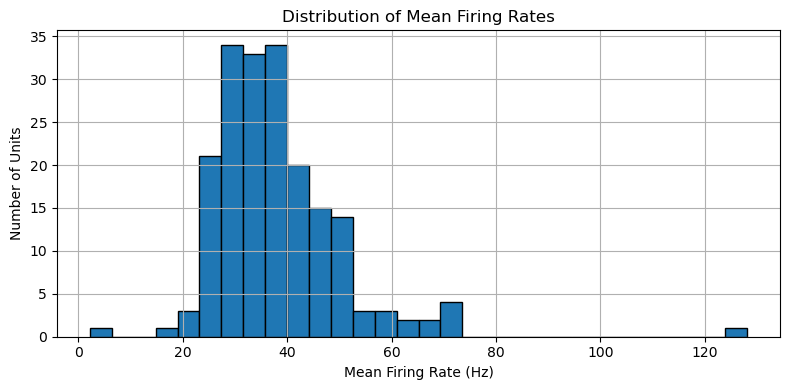

Mean firing rate across units: 38.16 Hz
Median: 36.17 Hz
Range: 2.21–128.09 Hz


In [10]:
# Compute mean firing rate (Hz) per unit
duration_sec = len(spk_cts_df) * bin_size
mean_firing_rates = spk_cts_df.sum(axis=0) / duration_sec  # spikes/sec

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(mean_firing_rates, bins=30, edgecolor='black')
plt.xlabel('Mean Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Mean Firing Rates')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary stats
print("Mean firing rate across units: {:.2f} Hz".format(mean_firing_rates.mean()))
print("Median: {:.2f} Hz".format(np.median(mean_firing_rates)))
print("Range: {:.2f}–{:.2f} Hz".format(mean_firing_rates.min(), mean_firing_rates.max()))

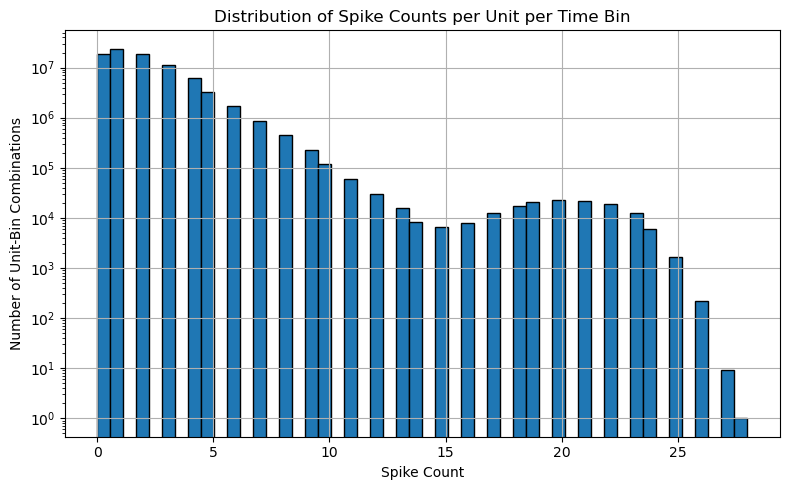

In [11]:
# Flatten the spike count matrix to a 1D array
flattened_spike_counts = spk_cts_df.values.flatten()

# Plot histogram of spike counts
plt.figure(figsize=(8, 5))
plt.hist(flattened_spike_counts, bins=50, edgecolor='black')
plt.title("Distribution of Spike Counts per Unit per Time Bin")
plt.xlabel("Spike Count")
plt.ylabel("Number of Unit-Bin Combinations")
plt.yscale("log")  # Optional: log scale to better visualize skewed distributions
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
"""Check sparsity of binned spike counts."""

frac_nonzero_bins = (spk_cts_df != 0).values.sum() / spk_cts_df.size
frac_nonzero_examples = (spk_cts_df.sum(axis=1) > 0).mean()
print(f"{frac_nonzero_bins=:.4f}")
print(f"{frac_nonzero_examples=:.4f}")

frac_nonzero_bins=0.7788
frac_nonzero_examples=1.0000


## Get environment / behavior (meta)data

In [13]:
# Collect data from all sessions into arrays
hand_data = defaultdict(list)
eye_data = defaultdict(list)
trial_data = defaultdict(list)

for i, session in enumerate(sessions):
    recording_date = session.session.recording_date
    
    # Hand data - extract timestamps and 2D arrays
    timestamps = session.hand.timestamps + recording_date
    acc = session.hand.acc_2d
    pos = session.hand.pos_2d
    vel = session.hand.vel_2d
    
    hand_data['timestamp'].append(timestamps)
    hand_data['acc_x'].append(acc[:, 0])
    hand_data['acc_y'].append(acc[:, 1])
    hand_data['pos_x'].append(pos[:, 0])
    hand_data['pos_y'].append(pos[:, 1])
    hand_data['vel_x'].append(vel[:, 0])
    hand_data['vel_y'].append(vel[:, 1])
    hand_data['session'].append(np.full(len(timestamps), i))
    
    # Eye data - extract timestamps and position arrays
    eye_timestamps = session.eye.timestamps + recording_date
    eye_pos = session.eye.pos
    
    eye_data['timestamp'].append(eye_timestamps)
    eye_data['pos_x'].append(eye_pos[:, 0])
    eye_data['pos_y'].append(eye_pos[:, 1])
    
    # Trial data - add recording_date to all time columns
    trial_data['start'].append(session.trials.start + recording_date)
    trial_data['end'].append(session.trials.end + recording_date)
    trial_data['target_on_time'].append(session.trials.target_on_time + recording_date)
    trial_data['go_cue_time'].append(session.trials.go_cue_time + recording_date)
    trial_data['move_begins_time'].append(session.trials.move_begins_time + recording_date)
    trial_data['move_ends_time'].append(session.trials.move_ends_time + recording_date)
    trial_data['maze_condition'].append(session.trials.maze_condition)
    trial_data['barriers'].append(session.trials.maze_num_barriers)
    trial_data['targets'].append(session.trials.maze_num_targets)
    trial_data['hit_position_x'].append([pos[0] for pos in session.trials.hit_target_position])
    trial_data['hit_position_y'].append([pos[1] for pos in session.trials.hit_target_position])
    trial_data['hit_position_angle'].append([np.degrees(np.arctan2(pos[1], pos[0])) for pos in session.trials.hit_target_position])

# Concatenate all arrays into final datasets
combined_hand_data = {}
for key, arrays in hand_data.items():
    combined_hand_data[key] = np.concatenate(arrays)

combined_eye_data = {}
for key, arrays in eye_data.items():
    combined_eye_data[key] = np.concatenate(arrays)

combined_trial_data = {}
for key, arrays in trial_data.items():
    combined_trial_data[key] = np.concatenate(arrays)

# Create final DataFrames
combined_hand_df = pd.DataFrame(combined_hand_data).set_index('timestamp')
combined_eye_df = pd.DataFrame(combined_eye_data).set_index('timestamp')
combined_trials_df = pd.DataFrame(combined_trial_data)

# Create unified timestamp index from all data sources
all_event_ts = np.concatenate([
    combined_trials_df['target_on_time'].values,
    combined_trials_df['go_cue_time'].values,
    combined_trials_df['move_begins_time'].values,
    combined_trials_df['move_ends_time'].values,
])

# Get unique timestamps across all data
all_ts = np.unique(np.concatenate([
    combined_hand_df.index.values,
    combined_eye_df.index.values,
    all_event_ts
]))

# Create master dataframe with unified timestamp index
metadata = pd.DataFrame(index=all_ts)
metadata.index.name = 'timestamp'

# Merge hand and eye data
metadata = metadata.join(combined_hand_df, how='left')
metadata = metadata.join(combined_eye_df, how='left', rsuffix='_eye')

# Add event column - mark timestamps that correspond to trial events
event_map = {
    'target_on_time': 'target_on',
    'go_cue_time': 'go_cue',
    'move_begins_time': 'move_begins',
    'move_ends_time': 'move_ends',
}
event_col = pd.Series(index=metadata.index, dtype="object")
for col, label in event_map.items():
    event_times = combined_trials_df[col].values
    mask = np.isin(metadata.index.values, event_times)
    event_col.iloc[mask] = label
metadata['event'] = event_col

# Add trial_idx column - assign each timestamp to its trial
# Use binary search to efficiently find which trial each timestamp belongs to
trial_idx_series = pd.Series(index=metadata.index, dtype='float64')

# Sort trials by start time for binary search
trial_sort_idx = np.argsort(combined_trials_df['start'].values)
starts = combined_trials_df['start'].values[trial_sort_idx]
ends = combined_trials_df['end'].values[trial_sort_idx]

# Find potential trial for each timestamp
timestamps = metadata.index.values
start_positions = np.searchsorted(starts, timestamps, side='right') - 1

# Check which timestamps are within valid trial intervals
valid_mask = (start_positions >= 0) & (start_positions < len(starts))
valid_positions = start_positions[valid_mask]
valid_timestamps = timestamps[valid_mask]

# Verify timestamps are before trial end times
end_mask = valid_timestamps <= ends[valid_positions]
final_valid_mask = np.zeros(len(timestamps), dtype=bool)
final_valid_mask[valid_mask] = end_mask

# Assign trial indices to timestamps
trial_indices = np.full(len(timestamps), np.nan)
trial_indices[final_valid_mask] = trial_sort_idx[valid_positions[end_mask]]
trial_idx_series.iloc[:] = trial_indices

metadata['trial_idx'] = trial_idx_series

# Map trial properties using the trial indices
metadata['maze_condition'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['maze_condition']
)
metadata['barriers'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['barriers']
)
metadata['targets'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['targets']
)
metadata['hit_position_x'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['hit_position_x']
)
metadata['hit_position_y'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['hit_position_y']
)
metadata['hit_position_angle'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['hit_position_angle']
)

# Add movement_angle column based on position difference
pos_delta_x = metadata['pos_x'].diff()
pos_delta_y = metadata['pos_y'].diff()
metadata['movement_angle'] = np.degrees(np.arctan2(pos_delta_y, pos_delta_x))

# Calculate speed and acceleration magnitudes from vector components
metadata['vel_magnitude'] = np.sqrt(
    metadata['vel_x'].values**2 + metadata['vel_y'].values**2
)
metadata['accel_magnitude'] = np.sqrt(
    metadata['acc_x'].values**2 + metadata['acc_y'].values**2
)

# Show result
print("Metadata:")
display(metadata)

Metadata:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,event,trial_idx,maze_condition,barriers,targets,hit_position_x,hit_position_y,hit_position_angle,movement_angle,vel_magnitude,accel_magnitude
timestamp,,,,,,,,,,,,,,,,,,,,
1.250028e+09,-597.299235,-707.867556,8.049750,-62.741854,-13.333198,-11.660984,0,8.9,-5.4,NaN,0.0,1,0,1,114,91,38.598461,NaN,17.713066,926.198064
1.250028e+09,-880.303924,-1072.450646,8.036417,-62.753515,-13.930497,-12.368851,0,8.8,-6.3,NaN,0.0,1,0,1,114,91,38.598461,-138.827620,18.629204,1387.474464
1.250028e+09,-1127.477697,-1461.898513,8.021889,-62.766592,-15.093806,-13.805885,0,8.6,-6.0,NaN,0.0,1,0,1,114,91,38.598461,-138.009078,20.455450,1846.172587
1.250028e+09,-1047.817355,-1481.310598,8.006229,-62.781127,-16.185452,-15.292648,0,9.0,-6.0,NaN,0.0,1,0,1,114,91,38.598461,-137.133291,22.267330,1814.442696
1.250028e+09,-953.681890,-1453.093462,7.989518,-62.797177,-17.189440,-16.768506,0,8.9,-5.7,NaN,0.0,1,0,1,114,91,38.598461,-136.155583,24.013739,1738.099467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.252555e+09,353.989503,-773.636272,-6.646397,45.468919,0.258292,-21.653282,2,1.4,108.3,NaN,5864.0,10,0,1,-13,111,96.679878,-89.690277,21.654823,850.777085
1.252555e+09,376.652978,-840.887306,-6.645996,45.446870,0.606768,-22.456458,2,1.5,108.0,NaN,5864.0,10,0,1,-13,111,96.679878,-88.956326,22.464654,921.389672
1.252555e+09,404.394438,-883.836808,-6.645184,45.424006,1.011598,-23.335057,2,1.1,108.0,NaN,5864.0,10,0,1,-13,111,96.679878,-87.966409,23.356974,971.958006


In [14]:
"""Bin the metadata to match spike counts."""

# Create metadata_binned with consistent timestamps
ts = spk_cts_df.index.values
metadata_binned = pd.DataFrame(index=pd.Index(ts, name='timestamp'))

# Assign each metadata row to a bin index (half-open [t, t+bin))
bin_ids = np.searchsorted(ts, metadata.index.values, side='right') - 1
bin_ids = np.clip(bin_ids, 0, len(ts) - 1)

# Handle event aggregation 
event_values = metadata['event'].values
event_mask = pd.notna(event_values)

if event_mask.any():
    event_bin_ids = bin_ids[event_mask]
    valid_events = event_values[event_mask].astype(str)
    
    # Create event assignments using vectorized operations
    event_agg = np.full(len(ts), None, dtype=object)
    
    # Calculate target bins for all events at once
    event_indices = np.arange(len(valid_events))
    target_bins = event_bin_ids + event_indices
    
    # Only assign events that fall within valid bin range
    valid_targets = target_bins < len(ts)
    event_agg[target_bins[valid_targets]] = valid_events[valid_targets]
else:
    event_agg = np.full(len(ts), None, dtype=object)

# Efficient nearest neighbor reindexing using searchsorted
metadata_timestamps = metadata.index.values
ts_positions = np.searchsorted(metadata_timestamps, ts, side='left')

# Handle edge cases and find true nearest neighbors
ts_positions = np.clip(ts_positions, 0, len(metadata_timestamps) - 1)

# For positions not at the start, check if the previous position is closer
mask = ts_positions > 0
left_positions = ts_positions.copy()
left_positions[mask] = ts_positions[mask] - 1

# Calculate distances to determine nearest
left_distances = np.abs(ts - metadata_timestamps[left_positions])
right_distances = np.abs(ts - metadata_timestamps[ts_positions])

# Choose the nearest position
final_positions = np.where(left_distances < right_distances, left_positions, ts_positions)

# Copy all columns from nearest metadata except event and trial_idx
for col in metadata.columns:
    if col not in ('event', 'trial_idx'):
        metadata_binned[col] = metadata[col].iloc[final_positions].values

# Insert distributed events
metadata_binned['event'] = event_agg

# Override trial_idx from GT intervals [start, end) to avoid NN bleed across gaps
starts = combined_trials_df['start'].to_numpy()
ends = combined_trials_df['end'].to_numpy()
order = np.argsort(starts)
s, e = starts[order], ends[order]

left  = ts
right = ts + bin_size  # each bin is [left, right)
# Candidate trial: last trial that starts before this bin ends
cand = np.searchsorted(s, right, side='right') - 1
# Bin belongs if it overlaps trial interval
valid = (cand >= 0) & (left < e[cand]) & (right > s[cand])

trial_idx_binned = np.full(len(ts), np.nan)
trial_idx_binned[valid] = order[cand[valid]]

metadata_binned['trial_idx'] = pd.Series(
    trial_idx_binned, index=metadata_binned.index, dtype='float64'
)

# Result: metadata for all trial bins, one row per bin
print("Metadata binned:")
display(metadata_binned)

Metadata binned:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,maze_condition,barriers,targets,hit_position_x,hit_position_y,hit_position_angle,movement_angle,vel_magnitude,accel_magnitude,event,trial_idx
timestamp,,,,,,,,,,,,,,,,,,,,
1.250028e+09,-597.299235,-707.867556,8.049750,-62.741854,-13.333198,-11.660984,0,8.9,-5.4,1,0,1,114,91,38.598461,NaN,17.713066,926.198064,None,0.0
1.250028e+09,724.633463,-71.462698,7.655547,-63.249608,-16.815844,-32.225624,0,8.7,-3.9,1,0,1,114,91,38.598461,-118.063401,36.349188,728.148730,None,0.0
1.250028e+09,613.795526,780.186457,7.105081,-64.290522,-2.472065,-3.925894,0,9.6,-5.3,1,0,1,114,91,38.598461,-122.293361,4.639370,992.691218,None,0.0
1.250028e+09,167.655239,-687.202806,7.087093,-64.293778,0.387421,-3.790765,0,10.9,-5.9,1,0,1,114,91,38.598461,-84.537078,3.810511,707.358449,None,0.0
1.250028e+09,637.710701,-271.089828,7.157022,-64.552845,7.045371,0.681572,0,9.4,-4.5,1,0,1,114,91,38.598461,6.609140,7.078262,692.939126,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.252555e+09,204.229638,-418.551212,-6.642353,45.375557,1.619787,-24.642683,2,1.4,108.5,10,0,1,-13,111,96.679878,-86.239304,24.695861,465.719725,None,5864.0
1.252555e+09,204.229638,-418.551212,-6.642353,45.375557,1.619787,-24.642683,2,1.4,108.5,10,0,1,-13,111,96.679878,-86.239304,24.695861,465.719725,None,5864.0
1.252555e+09,204.229638,-418.551212,-6.642353,45.375557,1.619787,-24.642683,2,1.4,108.5,10,0,1,-13,111,96.679878,-86.239304,24.695861,465.719725,None,5864.0


## Train/val split and normalise with trial-aware shuffling

In [15]:
spikes = spk_cts_df.values.astype(np.float32)
velocity = np.column_stack([
    metadata_binned["vel_x"].to_numpy(dtype=np.float32),
    metadata_binned["vel_y"].to_numpy(dtype=np.float32),
])

In [16]:
# Get unique trial indices and shuffle them
unique_trials = metadata_binned['trial_idx'].unique()
np.random.shuffle(unique_trials)

# Split trials into train/val sets (80/20 split)
n_train_trials = int(len(unique_trials) * 0.8)
train_trials = unique_trials[:n_train_trials]
val_trials = unique_trials[n_train_trials:]

# Create boolean masks for train/val based on trial membership
train_mask = metadata_binned['trial_idx'].isin(train_trials)
val_mask = metadata_binned['trial_idx'].isin(val_trials)

# Split and smooth spikes (avoiding cross-boundary leakage)
sigma = 0.05 / bin_size
spikes_train = gaussian_filter1d(spikes[train_mask], sigma=sigma, axis=0)
spikes_val = gaussian_filter1d(spikes[val_mask], sigma=sigma, axis=0)

# Normalize spikes (fit normalization on training data only)
train_max = np.max(spikes_train, axis=0, keepdims=True)
spikes_train = spikes_train / train_max
spikes_val = spikes_val / train_max

# Split velocity
velocity_train = velocity[train_mask]
velocity_val = velocity[val_mask]

# Extract trial IDs for reference
trial_ids_train = metadata_binned['trial_idx'][train_mask].values
trial_ids_val = metadata_binned['trial_idx'][val_mask].values

# Summary
print(f"Train set: {len(train_trials)} trials ({train_mask.sum()} time bins)")
print(f"Val set: {len(val_trials)} trials ({val_mask.sum()} time bins)")
print(f"Spike data shapes: train {spikes_train.shape}, val {spikes_val.shape}")

Train set: 4692 trials (357347 time bins)
Val set: 1173 trials (90120 time bins)
Spike data shapes: train (357347, 191), val (90120, 191)


## Set SAE config

In [17]:
# gpu for training
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

spk_train_t = t.from_numpy(spikes_train).to(device).to(dtype=t.bfloat16)

dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
# dsae_topk_map = {1024: 12, 2048: 24, 4096: 48}
dsae = max(dsae_topk_map.keys())
n_inst = 2

display(spk_cts)

device=device(type='cuda')


,0,1,2,3,4,5,6,7,8,9,10,11,...,179,180,181,182,183,184,185,186,187,188,189,190
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
1.252534e+09,2,0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,1,1,0,4,0
1.252534e+09,2,6,0,2,1,1,1,1,0,0,1,0,...,1,0,1,2,4,3,2,3,1,1,8,0
1.252534e+09,3,4,0,1,1,1,0,1,1,0,2,2,...,1,1,0,1,2,1,1,1,1,1,4,1
1.252534e+09,2,2,1,0,2,2,1,0,1,1,0,0,...,1,1,1,2,3,0,1,3,3,1,6,2
1.252534e+09,2,1,0,0,2,2,1,0,1,2,2,0,...,1,1,0,3,3,3,0,1,0,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.252555e+09,0,7,2,2,0,4,1,3,3,2,1,1,...,2,1,1,0,1,2,5,4,3,1,2,1
1.252555e+09,0,4,1,1,2,0,2,0,2,1,1,1,...,1,1,2,0,0,0,4,1,3,3,4,4
1.252555e+09,0,2,1,0,1,0,2,0,0,1,1,3,...,4,4,1,0,1,3,1,0,3,3,2,0


## Train MSAE

In [18]:
sae_cfg = mt.SaeConfig(
    n_input_ae=spk_train_t.shape[1],   # input dimension = #units
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = (spk_train_t.shape[0] // batch_sz) * n_epochs
log_freq = max(1, n_steps // n_epochs // 2)
dead_neuron_window = max(1, n_steps // n_epochs // 3)

data_log = mt.optimize(  # train model
    spk_cts=spk_train_t,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau,
)

SAE batch training step: 100%|██████████| 6960/6960 [05:34<00:00, 20.80it/s, loss=0.01119,  l0_mean=24.0, l0_std=7.602097511291504, frac_dead=0.85400390625] 


## Validate SAEs

In [19]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

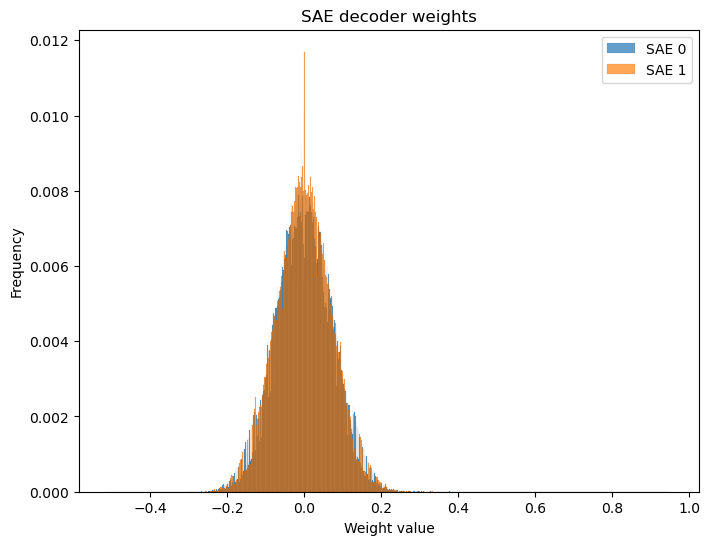

In [20]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step: 100%|██████████| 348/348 [00:03<00:00, 114.58it/s]
c:\Users\pouge\Documents\mini\.pixi\envs\default\lib\site-packages\IPython\core\events.py:82: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



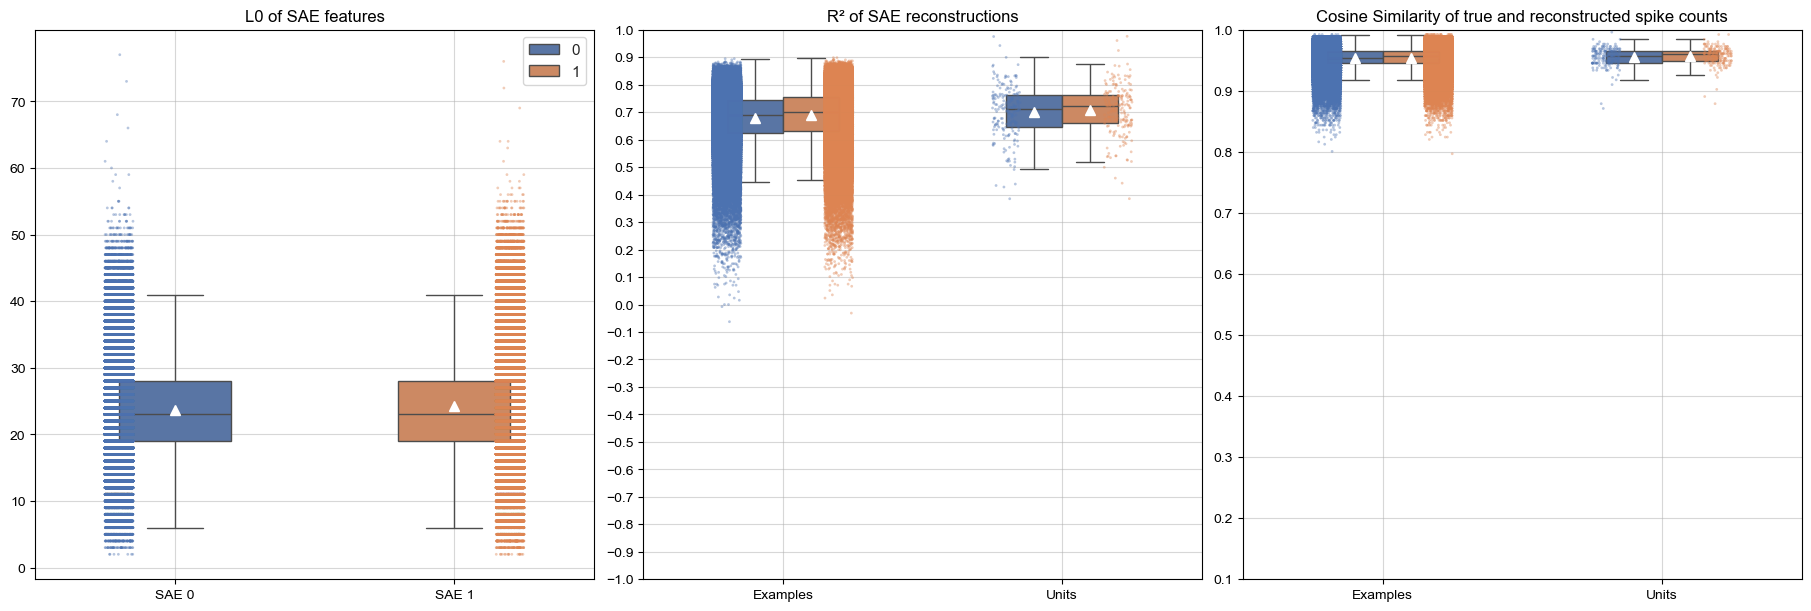

In [21]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(
    spk_train_t, sae, batch_sz=batch_sz
)

In [22]:
"""Calculate variance explained of summed spike counts."""

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")

actual_summed_spk_cts = reduce(spk_train_t, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[:n_recon_examples]  # trim to match

for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()),
        asnumpy(recon_summed_spk_cts[:, inst].float()),
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


SAE instance 0 R² (summed spike count over all units per example) = 0.996
SAE instance 1 R² (summed spike count over all units per example) = 0.997


In [23]:
# If cosine similarity is high but r2 is low, it suggests that the model is capturing the structure of the data but not the magnitude.
# Calculate scale ratio of norms to check this

# Expand to [n_examples, 1, n_units]
spk_train_exp = spk_train_t[:n_recon_examples].unsqueeze(1)

true_norms  = t.norm(spk_train_exp, dim=-1)   # [n_examples, 1]
recon_norms = t.norm(recon_spk_cts, dim=-1)   # [n_examples, n_instances]
scale = true_norms / recon_norms              # [n_examples, n_instances]

print(scale.mean(dim=0))  # if it’s consistently >1 or <1, your model is biased in magnitude

tensor([1.0625, 1.0625], device='cuda:0', dtype=torch.bfloat16)


In [24]:
spk_train_trim = spk_train_t[:n_recon_examples]
bias = (recon_spk_cts - spk_train_trim.unsqueeze(1)).mean(dim=0)
print(bias.mean(dim=0))  # mean bias per unit, averaged across examples

tensor([-0.0015, -0.0023, -0.0015, -0.0022, -0.0012, -0.0007, -0.0005, -0.0017,
        -0.0002, -0.0022, -0.0026, -0.0027, -0.0020, -0.0019, -0.0023, -0.0020,
        -0.0009, -0.0021, -0.0016, -0.0014, -0.0029, -0.0014, -0.0020, -0.0024,
        -0.0010, -0.0009, -0.0020, -0.0002, -0.0012, -0.0012, -0.0022, -0.0043,
        -0.0012, -0.0027, -0.0019, -0.0028, -0.0022, -0.0022, -0.0008, -0.0016,
        -0.0008, -0.0014, -0.0026, -0.0018, -0.0026, -0.0004, -0.0021, -0.0027,
        -0.0017, -0.0016, -0.0014, -0.0020, -0.0019, -0.0012, -0.0012, -0.0014,
        -0.0025, -0.0020, -0.0020, -0.0021, -0.0017, -0.0019, -0.0014, -0.0016,
        -0.0023, -0.0025, -0.0021, -0.0013, -0.0016, -0.0012, -0.0015, -0.0020,
        -0.0015, -0.0014, -0.0018, -0.0018, -0.0008, -0.0015, -0.0022, -0.0009,
        -0.0008, -0.0012, -0.0022, -0.0012, -0.0016, -0.0016, -0.0015, -0.0017,
        -0.0015, -0.0016, -0.0011, -0.0021, -0.0020, -0.0018, -0.0027, -0.0017,
        -0.0020, -0.0019, -0.0018, -0.00

In [25]:
true_var = spk_train_trim.var(dim=0).mean()
pred_var = recon_spk_cts.var(dim=0).mean()
print(f"True variance: {true_var.item():.4f}, Pred variance: {pred_var.item():.4f}")

True variance: 0.0141, Pred variance: 0.0099


### Remove bad units and retrain.

In [26]:

# Set threshold for removing units
r2_thresh = 0.1
inst = 0
r2_inst = r2_per_unit[:, inst]              # [n_units]
keep_mask = r2_inst > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Apply mask to train data (can be applied to val later)
spk_train_pruned = spk_train_t[:, keep_mask]

# Retrain SAE on pruned train data
sae_cfg = mt.SaeConfig(
    n_input_ae=spk_train_pruned.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = (spk_train_pruned.shape[0] // batch_sz) * n_epochs
log_freq = max(1, n_steps // n_epochs // 2)
dead_neuron_window = max(1, n_steps // n_epochs // 3)

data_log = mt.optimize(
    spk_cts=spk_train_pruned,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau,
)

frac units above r2_thresh=0.1: 1.00
Number to keep: 191 / 191


SAE batch training step: 100%|██████████| 6960/6960 [08:35<00:00, 13.50it/s, loss=0.01115,  l0_mean=24.0, l0_std=7.217738628387451, frac_dead=0.84033203125] 


SAE batch evaluation step: 100%|██████████| 348/348 [00:14<00:00, 24.68it/s]


[TRAIN] SAE instance 0 R² (summed spike count per example) = 0.996
[TRAIN] SAE instance 1 R² (summed spike count per example) = 0.997


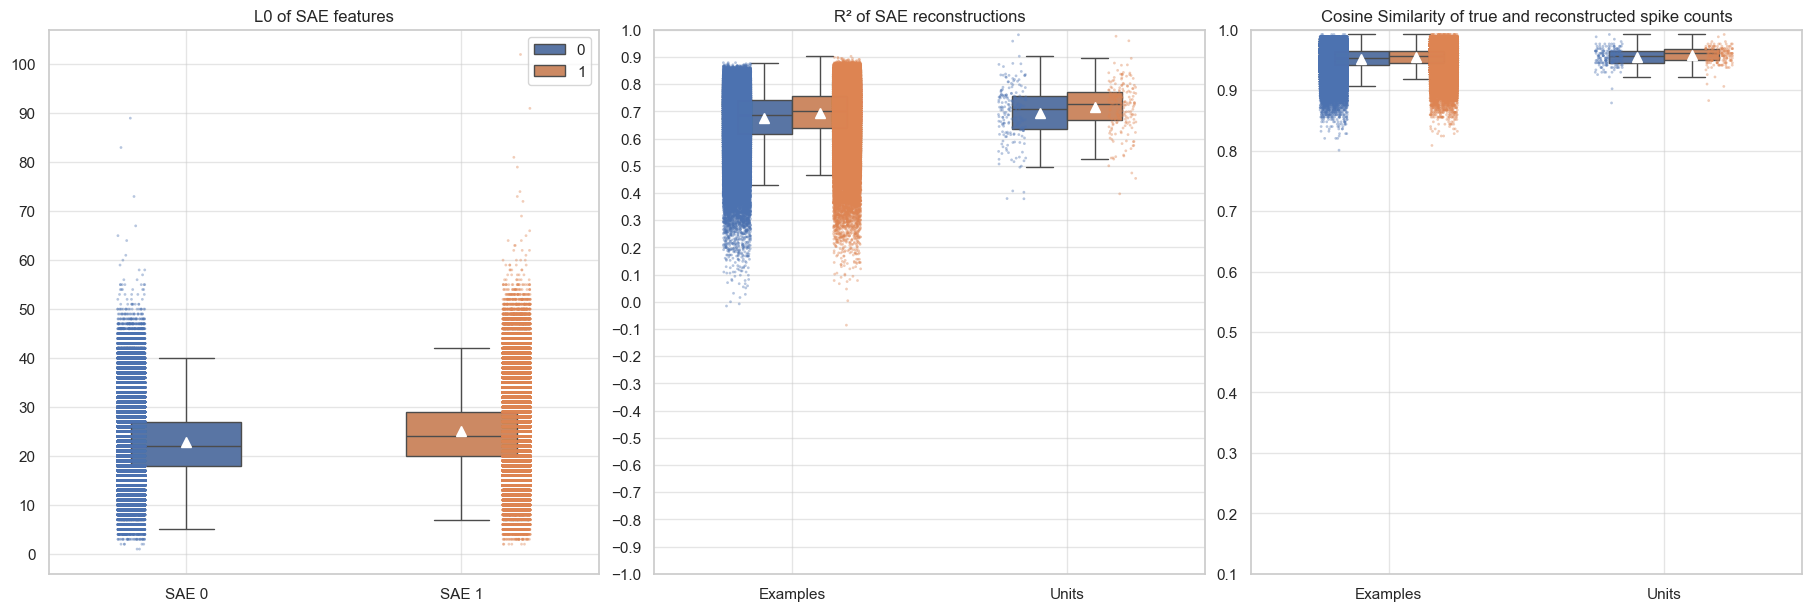

In [27]:
"""Re-visualize metrics over all examples and units."""

Xtr_t = spk_train_pruned

topk_acts_4d_tr, recon_spk_cts_tr, r2_per_unit_tr, _, cossim_per_unit_tr, _ = mt.eval_model(
    Xtr_t, sae, batch_sz=batch_sz
)

n_recon_examples_tr = recon_spk_cts_tr.shape[0]
recon_summed_tr = reduce(recon_spk_cts_tr, "example inst unit -> example inst", "sum")

actual_summed_tr = reduce(Xtr_t, "example unit -> example", "sum")
actual_summed_tr = actual_summed_tr[:n_recon_examples_tr]

for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_tr.float()),
        asnumpy(recon_summed_tr[:, inst].float()),
    )
    print(f"[TRAIN] SAE instance {inst} R² (summed spike count per example) = {r2:.3f}")

SAE batch evaluation step: 100%|██████████| 88/88 [00:00<00:00, 91.79it/s] 


[VAL] SAE instance 0 R² (summed spike count per example) = 0.996
[VAL] SAE instance 1 R² (summed spike count per example) = 0.997


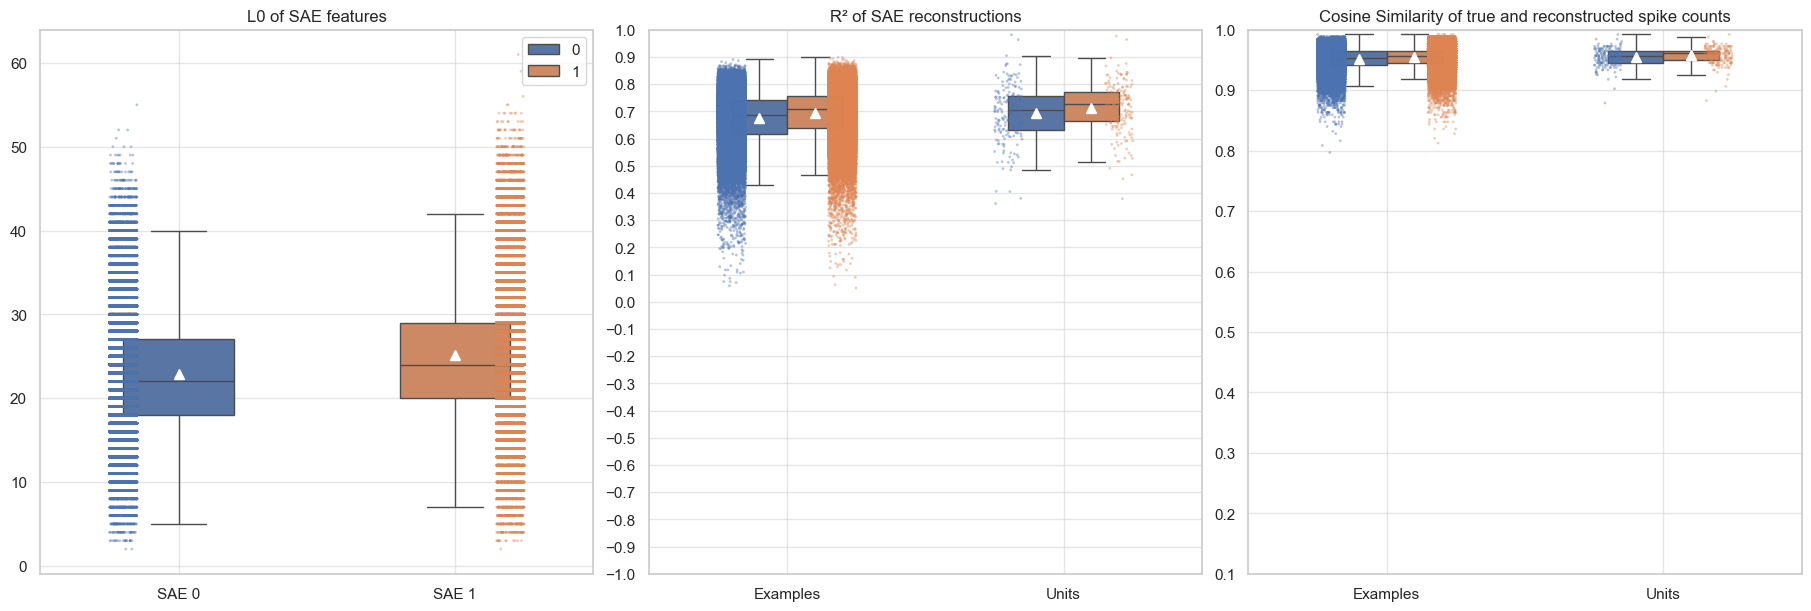

In [28]:
"""Do the same on validation data to check generalisation"""

Xva_np = spikes_val[:, keep_mask]  # apply same unit mask
Xva_t = t.from_numpy(Xva_np).to(Xtr_t.device).to(Xtr_t.dtype)

topk_acts_4d_va, recon_spk_cts_va, r2_per_unit_va, _, cossim_per_unit_va, _ = mt.eval_model(
    Xva_t, sae, batch_sz=batch_sz
)

n_recon_examples_va = recon_spk_cts_va.shape[0]
recon_summed_va = reduce(recon_spk_cts_va, "example inst unit -> example inst", "sum")

actual_summed_va = reduce(Xva_t, "example unit -> example", "sum")
actual_summed_va = actual_summed_va[:n_recon_examples_va]

for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_va.float()),
        asnumpy(recon_summed_va[:, inst].float()),
    )
    print(f"[VAL] SAE instance {inst} R² (summed spike count per example) = {r2:.3f}")


## Decode

In [40]:
"""Load saved activations (Etr/Eval) if available; otherwise (only if save_activations=True) densify from top-k and save."""

load_activations = True
save_activations = False
activations_file = "sae_activations.npz"

# Build save path (same style as before)
session_dates = []
for session in sessions:
    session_date = datetime.fromtimestamp(session.session.recording_date).strftime("%Y%m%d")
    session_dates.append(session_date)
session_dates_str = "_".join(session_dates)

activations_save_path = data_path / f"{subject_name}_{session_dates_str}" / "sae_activations" / activations_file
activations_save_path.parent.mkdir(parents=True, exist_ok=True)

if load_activations and activations_save_path.exists():
    # Load pre-saved activations/targets
    data = np.load(activations_save_path, allow_pickle=True)
    Etr, Eval = data["Etr"], data["Eval"]
    ytr, yva  = data["ytr"], data["yva"]
    print(f"Loaded activations from {activations_save_path}")
else:
    # Build Etr/Eval from top-k activations (sparse → dense)
    # Train
    arr_tr = asnumpy(topk_acts_4d_tr)  # [example_idx, instance_idx, feature_idx, activation_value]
    N_tr = int(arr_tr[:, 0].max()) + 1 if arr_tr.size else 0
    Etr = np.zeros((N_tr, n_inst * dsae), dtype=np.float32)
    cols_tr = (arr_tr[:, 1].astype(int) * dsae) + arr_tr[:, 2].astype(int)
    Etr[arr_tr[:, 0].astype(int), cols_tr] = arr_tr[:, 3].astype(float)

    # Val
    arr_va = asnumpy(topk_acts_4d_va)
    N_va = int(arr_va[:, 0].max()) + 1 if arr_va.size else 0
    Eval = np.zeros((N_va, n_inst * dsae), dtype=np.float32)
    cols_va = (arr_va[:, 1].astype(int) * dsae) + arr_va[:, 2].astype(int)
    Eval[arr_va[:, 0].astype(int), cols_va] = arr_va[:, 3].astype(float)

    # Targets aligned to available rows
    ytr, yva = velocity_train[:N_tr], velocity_val[:N_va]

    # Prune zero/near-zero-variance (and optionally ultra-rare) columns based on TRAIN only
    std_tr = Etr.std(axis=0, ddof=0)
    keep = std_tr > 1e-6
    # # Optional: also require a few nonzeros to avoid “almost dead” columns
    # nnz_tr = (Etr != 0).sum(axis=0)
    # keep &= nnz_tr >= 5

    dropped = int((~keep).sum())
    if dropped:
        Etr = Etr[:, keep]
        Eval = Eval[:, keep]
        print(f"Pruned {dropped} / {keep.size} features (std<=1e-6 or nnz<5). New D = {Etr.shape[1]}")

    if save_activations:
        np.savez(activations_save_path, Etr=Etr, Eval=Eval, ytr=ytr, yva=yva)
        print(f"Saved activations to {activations_save_path}")

print(f"Etr shape: {Etr.shape}, Eval shape: {Eval.shape}")

Loaded activations from C:\Users\pouge\Documents\mini_data\brainsets\processed\churchland_shenoy_neural_2012\nitschke_20090812_20090819_20090910\sae_activations\sae_activations.npz
Etr shape: (356352, 376), Eval shape: (90112, 376)


In [37]:
"""Check feature variance, sparsity, and conditioning"""

X = Et  # or Ev
std = X.std(axis=0, ddof=0)
nnz = (X != 0).sum(axis=0)

print("zero columns:", (std == 0).sum(), " / ", X.shape[1])
print("near-constant (std<1e-6):", (std < 1e-6).sum())
print("median nnz per column:", int(np.median(nnz)))

# Rough condition number on a smaller slice
svals = np.linalg.svd(X[:5000], compute_uv=False)  # sample rows
cond = svals.max() / max(svals.min(), 1e-12)
print("approx cond:", cond)

zero columns: 0  /  376
near-constant (std<1e-6): 0
median nnz per column: 2478
approx cond: 194008407592773.44


In [41]:
"""Train on Etr, decode on Eval with a small lag sweep."""

def apply_lag(E_tr, E_va, y_tr, y_va, lag_bins: int):
    if lag_bins > 0:
        Et, yt = E_tr[:-lag_bins], y_tr[lag_bins:]
        Ev, yv = E_va[:-lag_bins], y_va[lag_bins:]
    elif lag_bins < 0:
        k = -lag_bins
        Et, yt = E_tr[k:], y_tr[:-k]
        Ev, yv = E_va[k:], y_va[:-k]
    else:
        Et, yt, Ev, yv = E_tr, y_tr, E_va, y_va
    return Et, Ev, yt, yv

best = {"lag": 0, "r2_mean": -np.inf, "r2_per_dim": None, "decoder": None}

for lag in range(0, 6):
    Et, Ev, yt, yv = apply_lag(Etr, Eval, ytr, yva, lag)

    # Train on train, evaluate on val
    decoder = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        Ridge(alpha=30.0, solver="lsqr"),
    )
    decoder.fit(Et, yt)
    y_pred = decoder.predict(Ev)

    r2_per_dim = r2_score(yv, y_pred, multioutput='raw_values')
    r2_mean = float(np.mean(r2_per_dim))

    if r2_mean > best["r2_mean"]:
        best.update(lag=lag, r2_mean=r2_mean, r2_per_dim=r2_per_dim, decoder=decoder)

print(f"Best lag (bins): {best['lag']}")
print(f"R² per dimension: {best['r2_per_dim']}")
print(f"Mean R²: {best['r2_mean']}")

Best lag (bins): 3
R² per dimension: [0.5952498 0.4816565]
Mean R²: 0.5384531021118164
